# Calculate Dislocation

## Dislocation


In [1]:
import geopandas as gpd
import pandas as pd
import partisan_dislocation as pdn
import numpy as np

sample_pct = 0.07
num_dists = 15

knn = gpd.read_file(
    f"../20_intermediate_files/ohio_knn_{sample_pct:.2f}_sample_{num_dists}_dists.geojson"
)

knn = knn.to_crs(epsg=26917)

districts = {}
files = {
    "challenged": "challenged_daves",
    "housedems": "housedems_congress_11_5_21",
    "ocrc": "ocrc_09_30_21",
    "senatedems": "sendems_congress_11_10_21",
}
authors = files.keys()

for a in authors:
    districts[a] = gpd.read_file(f"../00_source_data/round2_2021_11_22/{files[a]}.shp")
    districts[a] = districts[a].to_crs(epsg=26917)
    assert len(districts[a]) == num_dists


In [2]:
knn = knn.to_crs(epsg=26917)


In [3]:
df = pdn.calculate_dislocation(
        knn,
        districts["challenged"],
        knn_column="knn_shr_dem",
        dem_column="dem",
        district_id_col="DISTRICT",
    )

In [4]:
df.sample().T

,259440
dem,1
knn_shr_dem,0.57689
district_dem_share,0.46051
partisan_dislocation,-0.11638
geometry,POINT (319710.57588144 4443952.000671996)
DISTRICT,15


In [9]:
dislocation_points = {}
dislocation_dists = {}
for a in authors:
    df = pdn.calculate_dislocation(
        knn,
        districts[a],
        knn_column="knn_shr_dem",
        dem_column="dem",
        district_id_col="DISTRICT",
    )

    df["dem_knn"] = (df["knn_shr_dem"] > 0.5).astype("int")
    df["dem_dist"] = (df["district_dem_share"] > 0.5).astype("int")

    df["party_misaligned_dem_knn_in_r_dist"] = df["dem_knn"] - df["dem_dist"]
    df["party_misaligned_binary"] = np.abs(df["party_misaligned_dem_knn_in_r_dist"])

    df["misaligned_harmed"] = 0
    df.loc[
        (df["party_misaligned_binary"] == 1)
        & ((df["dem_dist"] & df["dem"]) | (~df["dem_dist"] & ~df["dem"])),
        "misaligned_harmed",
    ] = 1

    dislocation_points[a] = df


## Binary Dislocations

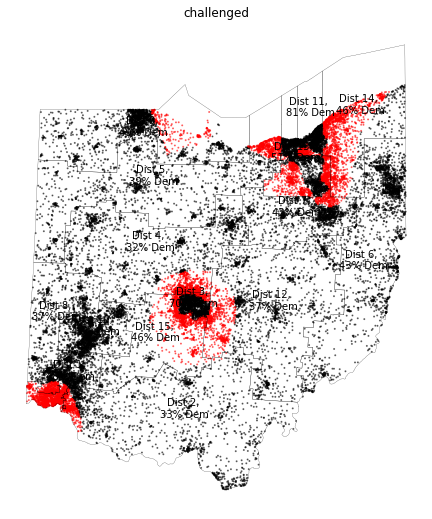

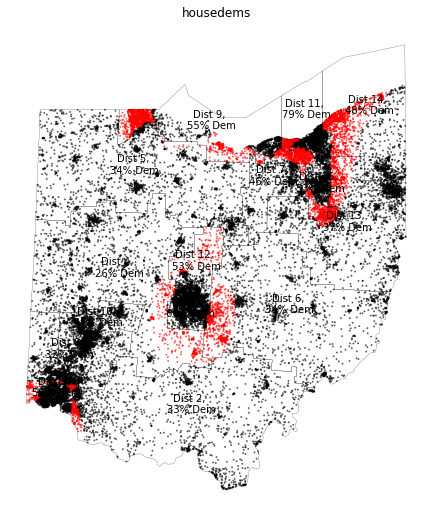

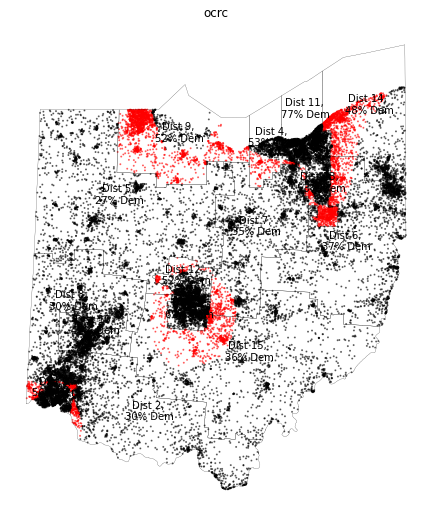

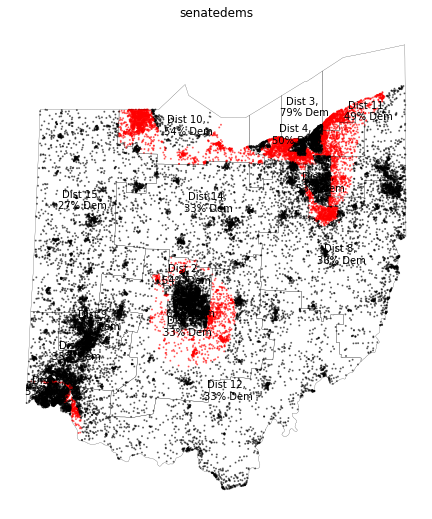

In [14]:
import matplotlib
black_red_cmap = matplotlib.colors.ListedColormap(['black', 'red'])


for a in authors:
    df = dislocation_points[a]
    ax = df.sample(frac=0.1).plot(
        "party_misaligned_binary",
        figsize=(9, 9),
        markersize=1,
        alpha=0.5,
        cmap = black_red_cmap
    )
    ax.set_title(a)

    dist_scores = df.groupby("DISTRICT", as_index=False)[
        ["party_misaligned_binary", "knn_shr_dem", "district_dem_share"]
    ].mean()

    dist = pd.merge(
        districts[a],
        dist_scores,
        on="DISTRICT",
        how="outer",
        validate="1:1",
        indicator=True,
    )
    dist._merge.value_counts()
    assert dist._merge.value_counts().loc["both"] == num_dists

    dist.boundary.plot(ax=ax, edgecolor="black", linewidth=0.2)

    dist.apply(
        lambda x: ax.annotate(
            text=f'Dist {x["DISTRICT"]}, \n{x["district_dem_share"]:.0%} Dem',
            xy=x.geometry.centroid.coords[0],
            ha="center",
        ),
        axis=1,
    )
    ax.set_axis_off()
    ax.figure.savefig(f"../30_results/binary_dislocation_{a}_points.png")


### Distribution of Binary Dislocations Across Voters


In [19]:

import altair as alt
# alt.data_transformers.enable('data_server')
all_points = list()
for a in authors:
    df = dislocation_points[a]
    df["author"] = a
    all_points.append(df.copy())
all_points = pd.concat(all_points)
hist = all_points.groupby(["party_misaligned_binary", "author", "dem"], as_index=False)[["DISTRICT"]].count()
hist["n"] = hist["DISTRICT"]
hist

,party_misaligned_binary,author,dem,DISTRICT,n
0,0,challenged,0,122804,122804
1,0,challenged,1,104731,104731
2,0,housedems,0,137717,137717
3,0,housedems,1,120569,120569
4,0,ocrc,0,141523,141523
5,0,ocrc,1,125664,125664
6,0,senatedems,0,135318,135318
7,0,senatedems,1,116769,116769
8,1,challenged,0,51466,51466
9,1,challenged,1,47474,47474


In [20]:


hist["total"] = hist.groupby(["dem", "author"], as_index=False)[["DISTRICT"]].transform(np.sum)
hist["share"] = hist.n / hist.total
hist.head(6)


,party_misaligned_binary,author,dem,DISTRICT,n,total,share
0,0,challenged,0,122804,122804,174270,0.704677
1,0,challenged,1,104731,104731,152205,0.688092
2,0,housedems,0,137717,137717,174270,0.790251
3,0,housedems,1,120569,120569,152205,0.792149
4,0,ocrc,0,141523,141523,174270,0.812090
5,0,ocrc,1,125664,125664,152205,0.825623


In [21]:
hist

,party_misaligned_binary,author,dem,DISTRICT,n,total,share
0,0,challenged,0,122804,122804,174270,0.704677
1,0,challenged,1,104731,104731,152205,0.688092
2,0,housedems,0,137717,137717,174270,0.790251
3,0,housedems,1,120569,120569,152205,0.792149
4,0,ocrc,0,141523,141523,174270,0.812090
5,0,ocrc,1,125664,125664,152205,0.825623
6,0,senatedems,0,135318,135318,174270,0.776485
7,0,senatedems,1,116769,116769,152205,0.767182
8,1,challenged,0,51466,51466,174270,0.295323
9,1,challenged,1,47474,47474,152205,0.311908


In [25]:
domain = [1, 0]
range_ = ['blue', 'red']
misaligned = hist[hist["party_misaligned_binary"] == 1]
c = (
    alt.Chart(pd.DataFrame(misaligned), title="Distribution of Misaligned Voters")
    .mark_bar(opacity=0.5)
    .encode(
        x=alt.X("dem:N"),
        y=alt.Y("share", stack=None, title="Share of Voters of Each Party Misaligned"),
        column="author",
        color=alt.Color("dem:N", scale=alt.Scale(domain=domain, range=range_)),
    )
)
c


alt.Chart(...)

In [26]:
c.save("../30_results/distribution_of_binary_miaslignment_by_party.png")

## Absolute Misalignment by District

For map by challenged:
Voters misaligned 30%
In most misaligned district for challenged, 91% of voters are misaligned
For map by housedems:
Voters misaligned 21%
In most misaligned district for housedems, 66% of voters are misaligned
For map by ocrc:
Voters misaligned 18%
In most misaligned district for ocrc, 89% of voters are misaligned
For map by senatedems:
Voters misaligned 23%
In most misaligned district for senatedems, 94% of voters are misaligned


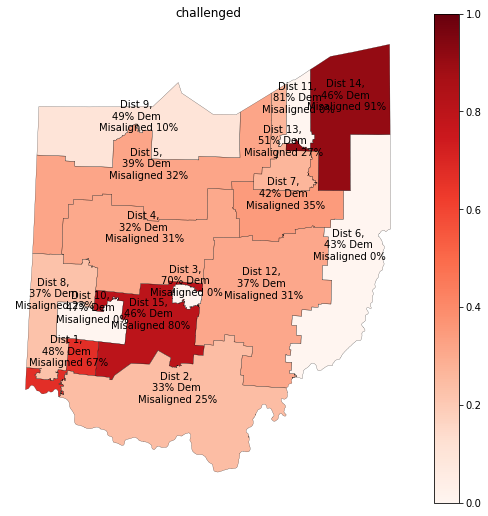

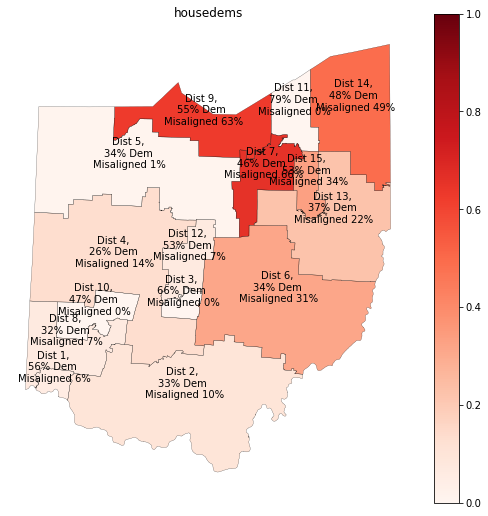

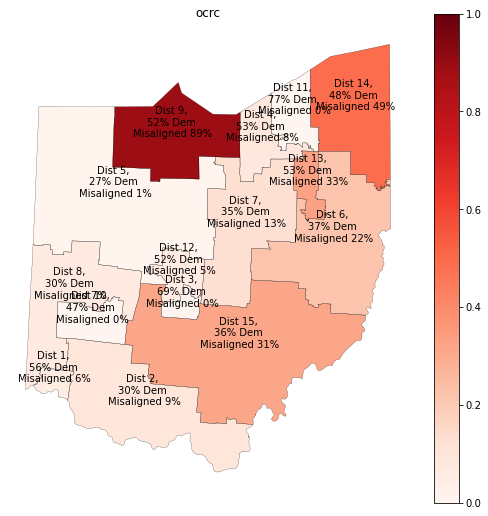

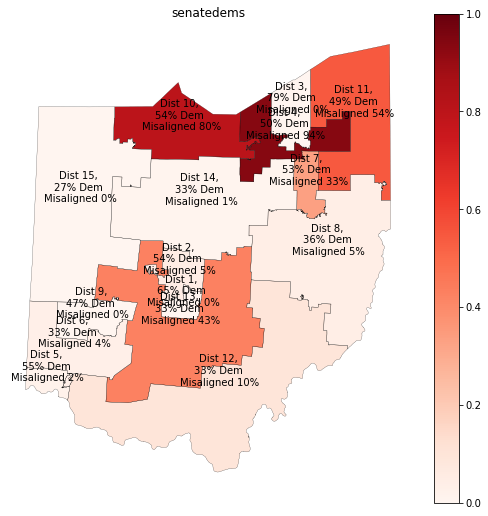

In [37]:
import pandas as pd

for a in authors:
    df = dislocation_points[a]
    print(f"For map by {a}:")
    print(
        f"Voters misaligned {df.party_misaligned_binary.mean():0.0%}"
    )

    dist_scores = df.groupby("DISTRICT", as_index=False)[
        ["party_misaligned_binary", "knn_shr_dem", "district_dem_share"]
    ].mean()

    dist = pd.merge(
        districts[a],
        dist_scores,
        on="DISTRICT",
        how="outer",
        validate="1:1",
        indicator=True,
    )
    dist._merge.value_counts()
    assert dist._merge.value_counts().loc["both"] == num_dists

    print(
        f"In most misaligned district for {a}, {dist.party_misaligned_binary.max():0.0%} of voters are misaligned"
    )

    ax = dist.plot(
        "party_misaligned_binary",
        cmap="Reds",
        legend=True,
        figsize=(9, 9),
        vmin=0,
        vmax=1,
    )
    dist.apply(
        lambda x: ax.annotate(
            text=f'Dist {x["DISTRICT"]}, \n{x["district_dem_share"]:.0%} Dem \nMisaligned {x["party_misaligned_binary"]:.0%}',
            xy=x.geometry.centroid.coords[0],
            ha="center",
        ),
        axis=1,
    )
    dist.boundary.plot(edgecolor="black", ax=ax, linewidth=0.2)
    ax.set_title(a)
    ax.set_axis_off()
    ax.figure.savefig(f"../30_results/misalignment_{a}_districts.png")


15

## Signed Dislocation

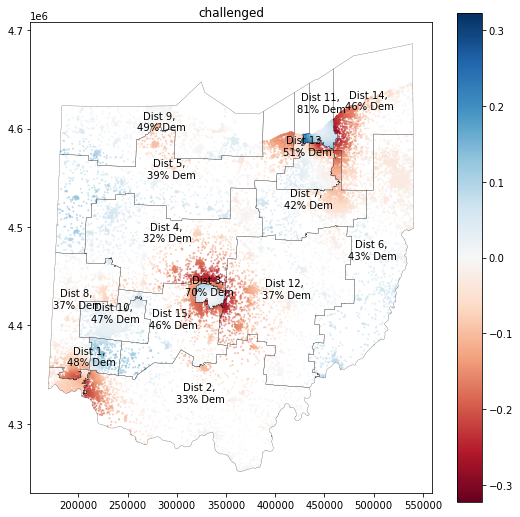

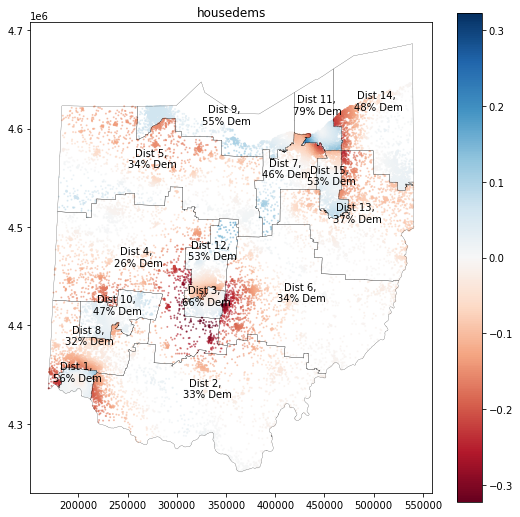

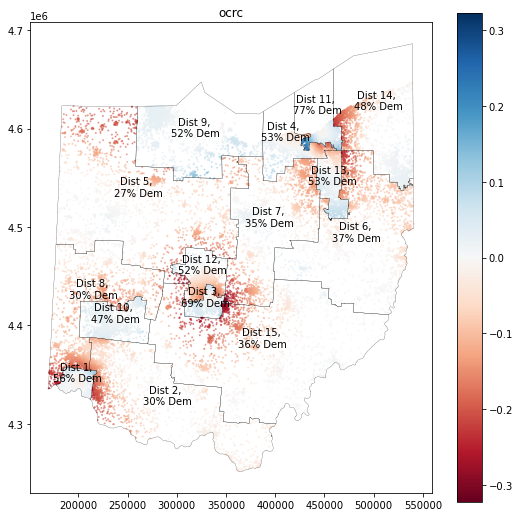

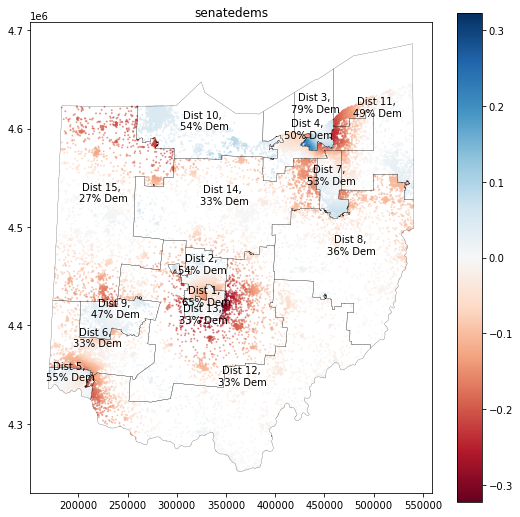

In [15]:

# Get extreme values
pd_max = 0
pd_min = 0
for a in authors:
    if candidate_max := df.partisan_dislocation.max():
        pd_max = candidate_max
    if candidate_min := df.partisan_dislocation.min():
        pd_min = candidate_min

limit = max([np.abs(pd_max), np.abs(pd_min)])

# Plot
for a in authors:
    df = dislocation_points[a]
    ax = df.sample(frac=0.1).plot(
        "partisan_dislocation",
        cmap="RdBu",
        legend=True,
        figsize=(9, 9),
        vmin=-limit,
        vmax=limit,
        markersize=1,
        alpha=0.5,
    )
    ax.set_title(a)


    dist_scores = df.groupby("DISTRICT", as_index=False)[
        ["abs_partisan_dislocation", "knn_shr_dem", "district_dem_share"]
    ].mean()

    dist = pd.merge(
        districts[a],
        dist_scores,
        on="DISTRICT",
        how="outer",
        validate="1:1",
        indicator=True,
    )
    dist._merge.value_counts()
    assert dist._merge.value_counts().loc["both"] == num_dists

    dist.boundary.plot(ax=ax, edgecolor="black", linewidth=0.2)

    dist.apply(
        lambda x: ax.annotate(
            text=f'Dist {x["DISTRICT"]}, \n{x["district_dem_share"]:.0%} Dem',
            xy=x.geometry.centroid.coords[0],
            ha="center",
        ),
        axis=1,
    )
    ax.figure.savefig(f"../30_results/{a}_signed_dislocation.png")
    


In [16]:
for a in authors:
    m = (
        dislocation_points[a][["partisan_dislocation", "geometry"]]
        .sample(frac=0.1)
        .explore("partisan_dislocation", cmap="RdBu", vmin=-0.35, vmax=0.35)
    )
    m.save(f"../20_intermediate_files/interactive_folium_map_{a}.html")
